<a href="https://colab.research.google.com/github/Untick/Selector_ObjDet/blob/Trokhachev-Anton-folder/Trokhachev%20Anton/%D0%A2%D1%80%D0%BE%D1%85%D0%B0%D1%87%D0%B5%D0%B2%20%D0%90%D0%BD%D1%82%D0%BE%D0%BD%20-%20CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Lambda, LeakyReLU

# Оптимизаторы для обучения модели
from tensorflow.keras.optimizers import Adam

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Загрузка сохраненной модели
from tensorflow.keras.models import load_model

# класс для использования Functional API
from tensorflow.keras import Model

# Отрисовка изображения
from tensorflow.keras.preprocessing import image

# Импортируем Keras
from tensorflow import keras

# Импортируем Keras
import keras

# Подключим модуль вычислений на Keras
import keras.backend as K

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split 

# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Работа с таблицами
import pandas as pd

from PIL import Image
import cv2

# Отрисовка графиков
import matplotlib.pyplot as plt 

%matplotlib inline

In [ ]:
gdown.download('https://storage.yandexcloud.net/terratraineeship/23_Selector_newbies/datasets/processed%20extended%20dataset.zip', None, quiet=True)

'processed%20extended%20dataset.zip'

In [ ]:
!unzip -qq -o processed%20extended%20dataset.zip -d dataset/

In [ ]:
IMG_WIDTH = 200
IMG_HEIGHT = 200
CHANELS = 1
num_classes = 13

FILE_DIR  = 'dataset'
dir_list = os.listdir(FILE_DIR)
CLASS_LIST = sorted(os.listdir(FILE_DIR))
CLASS_COUNT = len(CLASS_LIST)

image_array = []
data_labels = []
class_label = 0

FILE_DIR  = 'dataset'
dir_list = os.listdir(FILE_DIR)
image_array = []

for i in dir_list:
  class_label += 1
  file_list = os.listdir(f'dataset/{i}')
  ch = 0
  dl = len(file_list)
  for image in file_list[:50]:
    try:
      img = Image.open(f'dataset/{i}/{image}').resize((IMG_HEIGHT, IMG_WIDTH)).convert("L")
      img_np = np.array(img)
      image_array.append(img_np)
      ch += 1
    except:
      print(f'При обработке файла {i}/{image} произошла ошибка')
      pass
  print(f'Каталог {i} обработан, добавлено {ch} изображений из {dl}')
  data_labels += [class_label] * ch

image_array = np.array(image_array)
image_array = image_array.reshape(-1,IMG_HEIGHT,IMG_WIDTH,CHANELS)
image_array = image_array.astype('float32')
image_array /= 255

x_data = image_array
y_data = np.array(data_labels)

#print(x_data.shape)
#print(y_data.shape)

x_train, x_test, y_train, y_test = train_test_split(x_data, # набор параметров
                                                    y_data, # набор меток классов
                                                    test_size=0.2, # процент в тестовую
                                                    shuffle=True, #  перемешивание
                                                    random_state=3) # воспроизводимость

#print(x_train.shape)
#print(y_train.shape)
#print(x_test.shape)
#print(y_test.shape)

y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

#print(y_train_cat.shape)
#print(y_test_cat.shape)

Каталог t-shirt men обработан, добавлено 50 изображений из 994
Каталог shirt men обработан, добавлено 50 изображений из 3235
Каталог t-shirt women обработан, добавлено 50 изображений из 1004
Каталог dress homemade обработан, добавлено 50 изображений из 975
Каталог trousers men обработан, добавлено 50 изображений из 1967
Каталог dress solemn обработан, добавлено 50 изображений из 1004
Каталог dress casual обработан, добавлено 50 изображений из 805
Каталог dress  business обработан, добавлено 50 изображений из 943
Каталог trousers women обработан, добавлено 50 изображений из 1037
Каталог sportswear men обработан, добавлено 50 изображений из 936
Каталог shirt women обработан, добавлено 50 изображений из 1034
Каталог sportswear women обработан, добавлено 50 изображений из 1018
(600, 200, 200, 1)
(600,)


In [ ]:
# Функция сборки автокодировщика по частям
    # ЭНКОДЕР
    # Вход
batch_size = 100
latent_dim = 13
in_shape = x_train.shape[1:3]

input_img = Input((200, 200, 1))       # Добавим входной слой
fl = Flatten()(input_img)             # Добавим Flatten
lb = Input(shape=(num_classes,))     # Добавим входной слой для метки класса
x = concatenate([fl, lb])            # конкатенируем метку класса изображение 

x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
# Кодированное полносвязным слоем представление (вектор латентного пространства)
encoded = Dense(latent_dim, activation='relu')(x)    

# ДЕКОДЕР
# Вход
input_dec = encoded
#input_dec = Input(shape=(latent_dim,))     # Добавим входной слой
lb_dec = Input(shape=(num_classes,))        # Добавим вход для метки класса
d = concatenate([input_dec, lb_dec])        # Конкатенируем метку класса и вектор скрытого пространства

d = Dense(128, activation='relu')(d)
d = Dense(256, activation='relu')(d)
d = Dense(512, activation='relu')(d)
# Раскодированное другим полносвязным слоем изображение в виде плоского вектора
d = Dense(200*200, activation='sigmoid')(d)   # Добавим выходной dense
decoded = Reshape((200, 200, 1))(d)           # Решейпим до исходной размерности картинки 

# Модели, в конструктор первым аргументом передаются входные слои, а вторым выходные слои
# Другие модели можно так же использовать, как и слои
#inputs=[input_message,input_description,input_errors,input_panics,input_images,input_committer,input_reporter ], outputs=z
encoder = Model([input_img, lb], encoded, name='encoder')
decoder = Model([input_dec, lb_dec], decoded, name='decoder')

    #outputs = decoder([encoder(input_img, lb, lb_dec)])

    # Построение модели автокодировщика (внутри двойное преобразование - сжатие/разжатие)
    #[input_img, lb, lb_dec], outputs , name="cvae"
autoencoder = Model([input_img, lb, lb_dec], decoded, name="autoencoder")




In [ ]:
# Проверим состав энкодера
#encoder.summary()

# Проверим состав декодера
#decoder.summary()

# Компилируем VAE
autoencoder.compile(optimizer='adam', loss='mse') # оптимайзер ADAM


# Обучим модель
autoencoder.fit([x_train, y_train_cat, y_train_cat],  # Обучающая выборка + метки классов для энкодера и декодера
         x_train,                              # Обучающая выборка
         epochs=30,                            # Число эпох
         batch_size=batch_size,                # Размер батча
         shuffle=True)                         # Обучающую выборку перемешиваем

Epoch 1/30
5/5 [==============================] - 6s 865ms/step - loss: 0.0883
Epoch 2/30
5/5 [==============================] - 5s 1s/step - loss: 0.0726
Epoch 3/30
5/5 [==============================] - 4s 848ms/step - loss: 0.0685
Epoch 4/30
5/5 [==============================] - 4s 851ms/step - loss: 0.0604
Epoch 5/30
5/5 [==============================] - 5s 1s/step - loss: 0.0517
Epoch 6/30
5/5 [==============================] - 4s 854ms/step - loss: 0.0474
Epoch 7/30
5/5 [==============================] - 5s 1s/step - loss: 0.0435
Epoch 8/30
5/5 [==============================] - 5s 843ms/step - loss: 0.0410
Epoch 9/30
5/5 [==============================] - 4s 849ms/step - loss: 0.0391
Epoch 10/30
5/5 [==============================] - 6s 1s/step - loss: 0.0374
Epoch 11/30
5/5 [==============================] - 4s 867ms/step - loss: 0.0358
Epoch 12/30
5/5 [==============================] - 4s 859ms/step - loss: 0.0352
Epoch 13/30
5/5 [==============================] - 6s 1s/step

In [ ]:
images = x_train
lb = lb_dec = y_train_cat
codes = encoder.predict([x_train, lb], batch_size=batch_size)
#print(codes[:1])
assert len(codes) == len(images)

from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)
#print(codes[:1])

5/5 [==============================] - 0s 80ms/step


NearestNeighbors(metric='euclidean')

In [ ]:
def get_similar(image, lb2, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"
    code = code = encoder.predict([image[None], lb2[None]], batch_size=batch_size)  
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    return distances,images[idx]
def show_similar(num_img):
    image = x_train[num_img]
    lb2 = lb[num_img]
    distances,neighbors = get_similar(image, lb2, n_neighbors=12)
    plt.figure(figsize=[16,14])
    plt.subplot(1,4,1)
    plt.imshow(image, cmap='gray')
    plt.title("Выбранное изображение")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        plt.imshow(neighbors[i], cmap='gray')
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

1/1 [==============================] - 0s 34ms/step


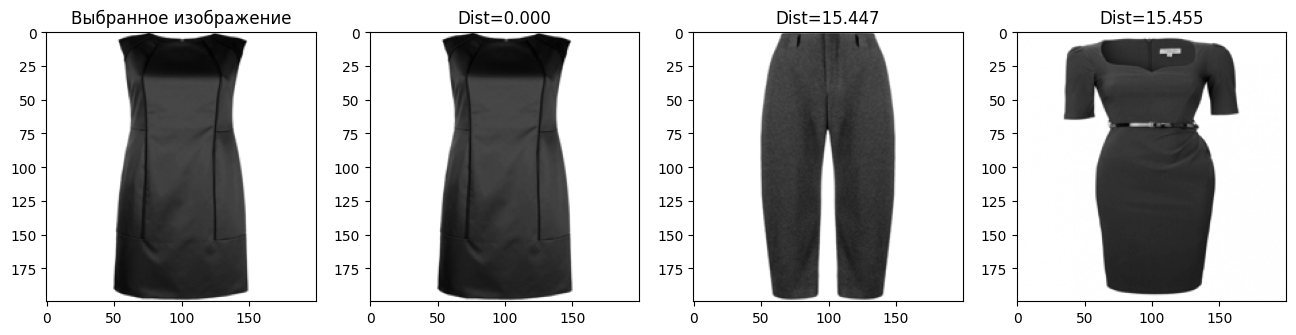

1/1 [==============================] - 0s 42ms/step


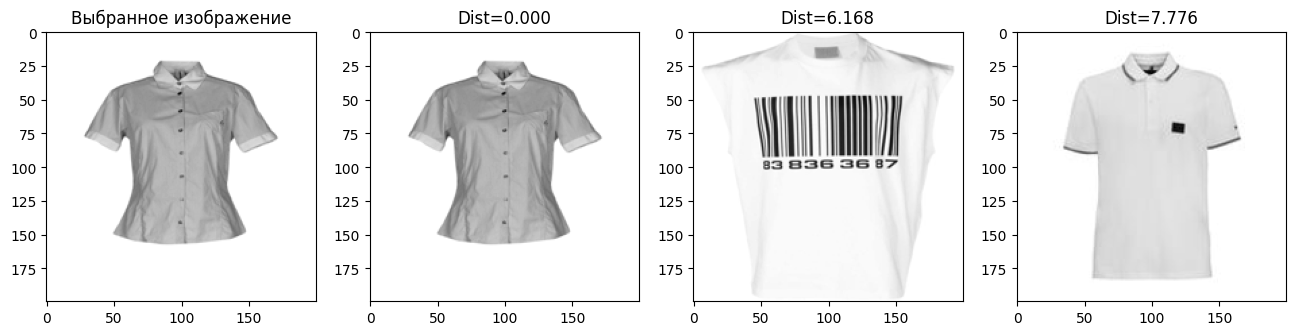

1/1 [==============================] - 0s 38ms/step


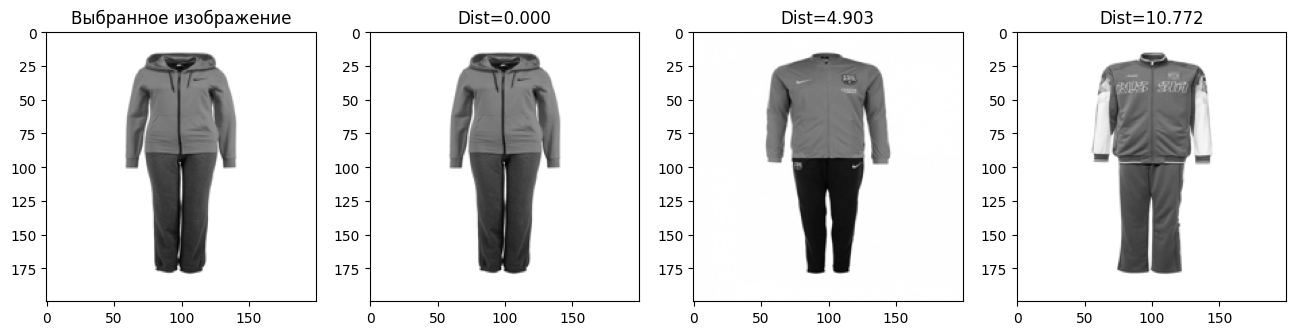

1/1 [==============================] - 0s 33ms/step


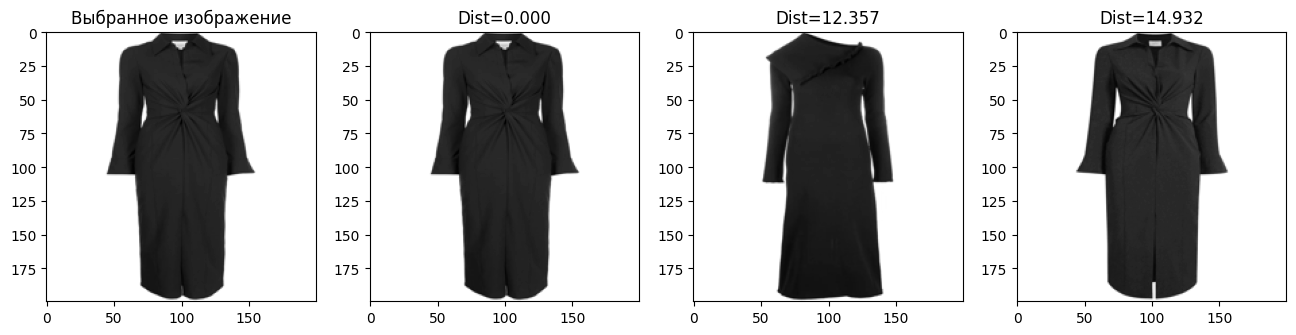

1/1 [==============================] - 0s 40ms/step


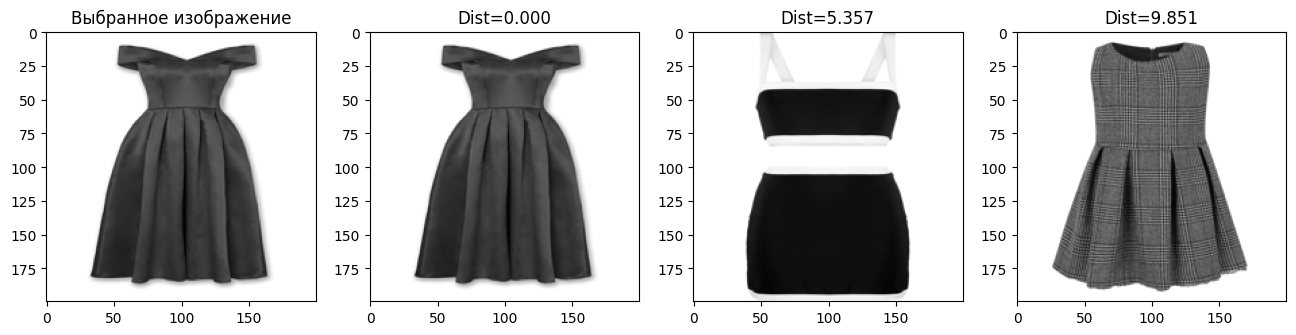

1/1 [==============================] - 0s 35ms/step


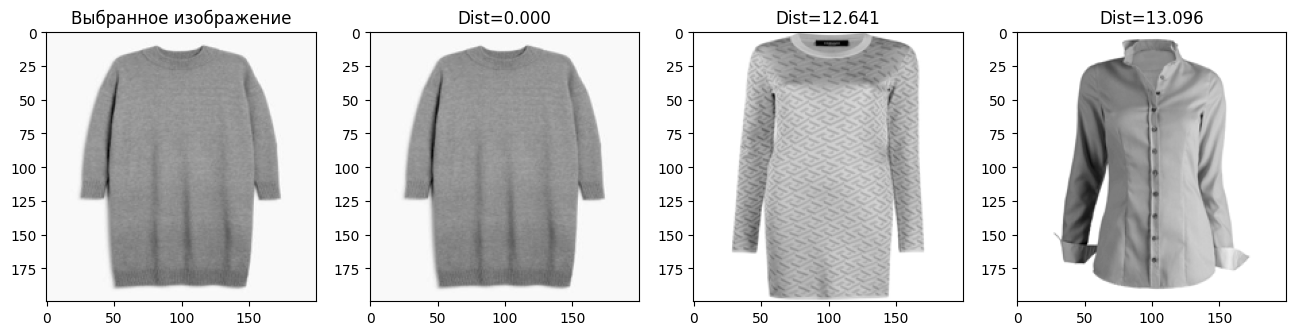

1/1 [==============================] - 0s 43ms/step


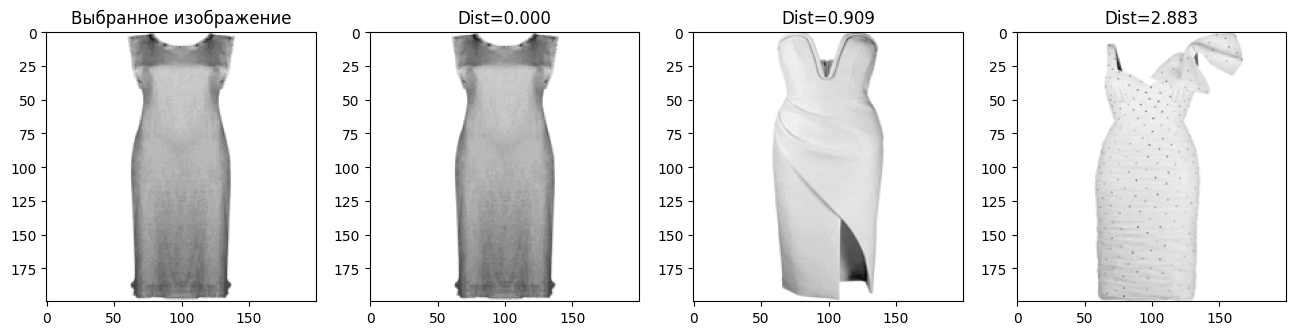

1/1 [==============================] - 0s 62ms/step


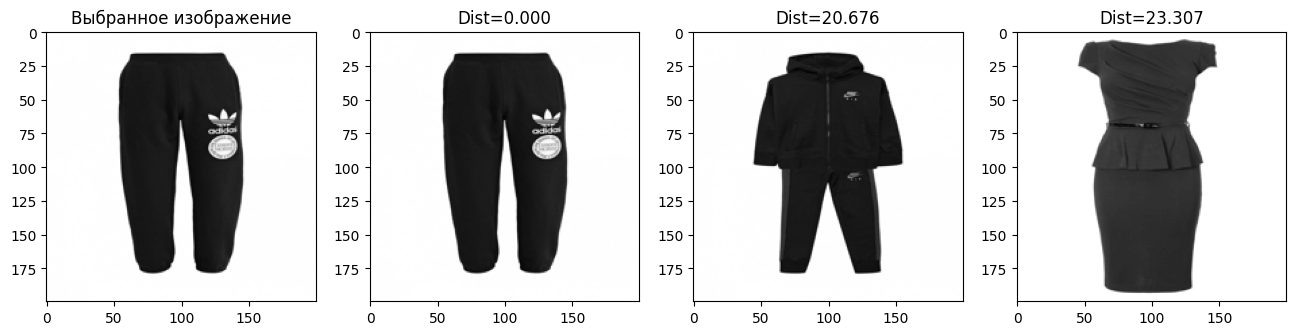

1/1 [==============================] - 0s 37ms/step


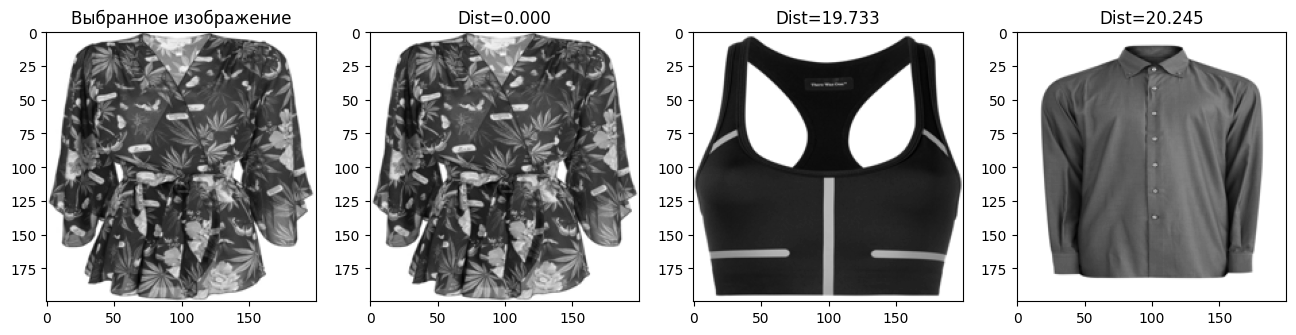

1/1 [==============================] - 0s 42ms/step


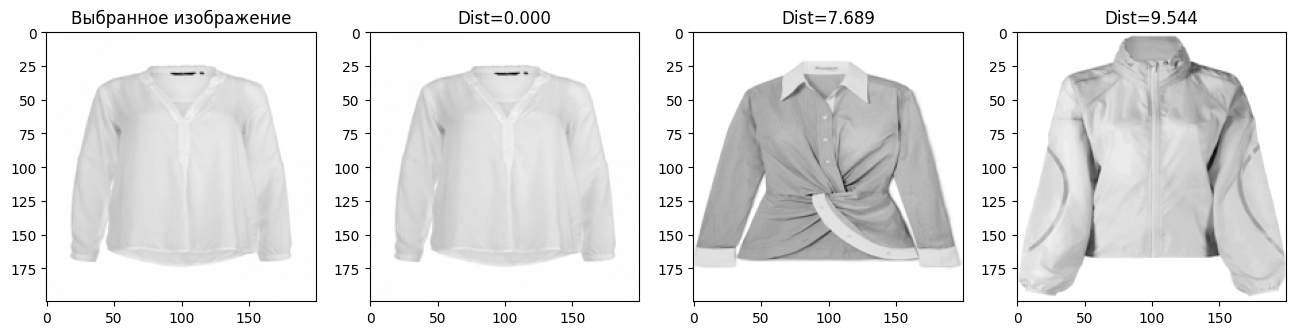

In [ ]:
show_similar(1)
show_similar(51)
show_similar(101)
show_similar(151)
show_similar(201)
show_similar(251)
show_similar(301)
show_similar(351)
show_similar(401)
show_similar(451)